<a href="https://colab.research.google.com/github/yj5x/AI-tasks/blob/main/task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification of Amazon Food Reviews

## 1. **Objective**
The objective of this project is to develop a robust deep learning model capable of accurately classifying the sentiment of product reviews on Amazon. This task requires the integration of various skills, ranging from text preprocessing to the application of deep learning techniques in natural language processing, along with performance evaluation on a real-world e-commerce dataset.


In [ ]:
!pip install scikeras
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d snap/amazon-fine-food-reviews -f Reviews.csv --unzip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
# Import required libraries
!pip install scikeras

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import re
import pandas as pd
import datetime

## 2. 📦 **Dataset**

- **🔗 Dataset Link**: [Amazon Fine Food Reviews Dataset](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews)

- **📝 Description**:  
  The dataset contains over **500,000** food-related reviews, including review texts and user ratings.  
  The goal is to classify the reviews based on their rating as follows:

  - ⭐️ **Negative**: 1–2 stars  
  - ⭐️ **Positive**: 4–5 stars  
  - ⭐️ **Neutral**: 3-star reviews (can be dropped or handled separately as needed)


In [ ]:
# Load the data
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
print("Path to dataset files:", path)

data = pd.read_csv(os.path.join(path, "Reviews.csv"))

Path to dataset files: /kaggle/input/amazon-fine-food-reviews


## 3. 🔄 **Workflow Steps**

### 3.1 🔍 **Data Exploration**
The process begins with downloading the dataset and exploring its structure, including the number of rows, columns, and the types of data present. This step helps in understanding the overall shape of the data and identifying any necessary preprocessing.


In [ ]:
# Explore the data
# Number of rows and columns
print("Number of rows and columns:", data.shape)

print()
print()

# First 5 rows of the data
display(data.head())

print()
print()

# Overview of data types and missing values
data.info()

print()
print()

# Overview of content in each column
for col in data.columns:
    display(f"{col}: {data[col].unique()[:5]}")
    print()
    print()

Number of rows and columns: (568454, 10)




,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB




'Id: [1 2 3 4 5]'

"ProductId: ['B001E4KFG0' 'B00813GRG4' 'B000LQOCH0' 'B000UA0QIQ' 'B006K2ZZ7K']"

"UserId: ['A3SGXH7AUHU8GW' 'A1D87F6ZCVE5NK' 'ABXLMWJIXXAIN' 'A395BORC6FGVXV'\n 'A1UQRSCLF8GW1T']"

'ProfileName: [\'delmartian\' \'dll pa\' \'Natalia Corres "Natalia Corres"\' \'Karl\'\n \'Michael D. Bigham "M. Wassir"\']'

'HelpfulnessNumerator: [1 0 3 4 2]'

'HelpfulnessDenominator: [1 0 3 4 2]'

'Score: [5 1 4 2 3]'

'Time: [1303862400 1346976000 1219017600 1307923200 1350777600]'

'Summary: [\'Good Quality Dog Food\' \'Not as Advertised\' \'"Delight" says it all\'\n \'Cough Medicine\' \'Great taffy\']'

'Text: [\'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.\'\n \'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".\'\n \'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\\\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.\'\n \'If y

In [ ]:
print()
print()

# Drop irrelevant columns
data.drop(['Id', 'UserId', 'ProfileName'], axis=1, inplace=True)


# Check for missing values in relevant columns
display(data.isnull().sum())

print()
print()

# Check for strange values using descriptive statistics
# This function provides a statistical summary for numerical columns
# Currently, there are 4 numerical columns

data.describe()

,0
ProductId,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
# Drop rows with missing values

data.dropna(inplace=True)

# Verify missing values are handled
display(data.isnull().sum())
data.describe()

,0
ProductId,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,0
Text,0


,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568427.000000,568427.000000,568427.000000,5.684270e+05
mean,1.743855,2.227859,4.183299,1.296262e+09
std,7.636692,8.288679,1.310385,4.803749e+07
min,0.000000,0.000000,1.000000,9.393408e+08
25%,0.000000,0.000000,4.000000,1.271290e+09
50%,0.000000,1.000000,5.000000,1.311120e+09
75%,2.000000,2.000000,5.000000,1.332720e+09
max,866.000000,923.000000,5.000000,1.351210e+09


## 📊 Converting Timestamps and Analyzing Data by Year

This section describes a series of preprocessing steps applied to a dataset containing Unix timestamps (in seconds) representing when each review was made. The goal is to convert these timestamps into human-readable dates, extract the year from each date, and then analyze the distribution of reviews over time.

### 🔄 Step 1: Convert Timestamps to Datetime
The `Time` column contains Unix timestamps, which are converted to datetime format using `pd.to_datetime()` with the `unit='s'` parameter to indicate that the timestamps are in seconds. The resulting datetime values are stored in a new column called `Date`.

```python
data['Date'] = pd.to_datetime(data['Time'], unit='s')


In [ ]:
# Convert timestamps to dates
data['Date'] = pd.to_datetime(data['Time'], unit='s')

# Add Year column
data['Year'] = data['Date'].dt.year

# Drop Time column
data.drop(['Time'], axis=1, inplace=True)


# Group data by year
grouped = data.groupby('Year').size()

# Display results
print(grouped)

# First 5 rows of data
display(data.head())

Year
1999         6
2000        32
2001        13
2002        73
2003       132
2004       561
2005      1335
2006      6671
2007     22275
2008     34163
2009     55326
2010     85884
2011    163299
2012    198657
dtype: int64


,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Date,Year
0,B001E4KFG0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011
1,B00813GRG4,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012
2,B000LQOCH0,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008
3,B000UA0QIQ,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011
4,B006K2ZZ7K,0,0,5,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012


### 3.2 📊 **Visualizing the Data Distribution**

To better understand the balance of sentiment classes in the dataset, we visualize the distribution of review ratings.  
This helps identify any class imbalance (e.g., significantly more positive reviews than negative ones), which can impact model performance and guide preprocessing decisions like resampling or weighting.


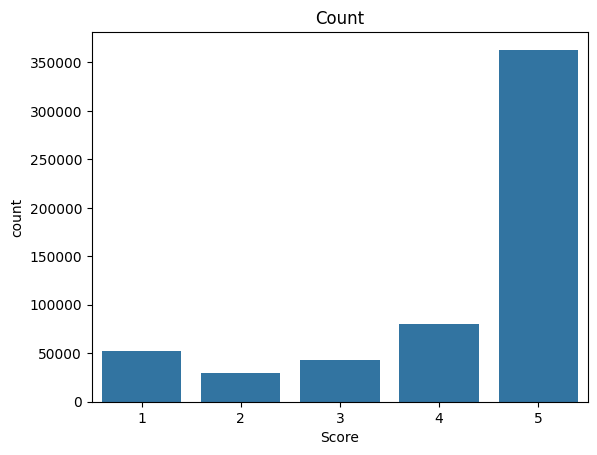

In [ ]:
## EDA

# Analyze the Score column
# Plot distribution
sns.countplot(data, x="Score")
plt.title("Count")
plt.show()

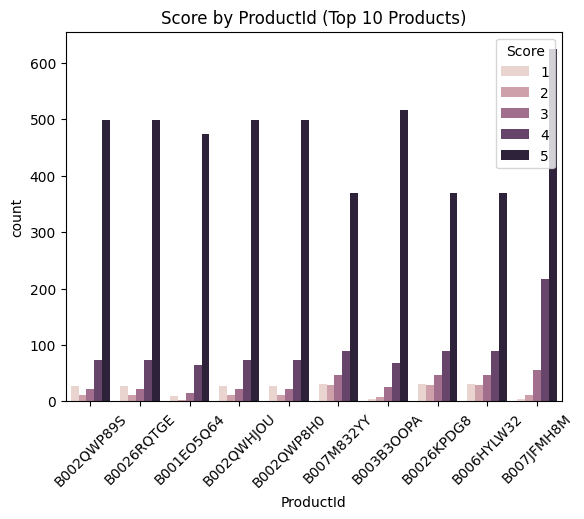

In [ ]:
# Select top 10 products
top_products = data['ProductId'].value_counts().nlargest(10).index

# Plot the bar chart only for the top 10 products
sns.countplot(x='ProductId', hue='Score', data=data[data['ProductId'].isin(top_products)])
plt.title("Score by ProductId (Top 10 Products)")
plt.xticks(rotation=45)
plt.show()

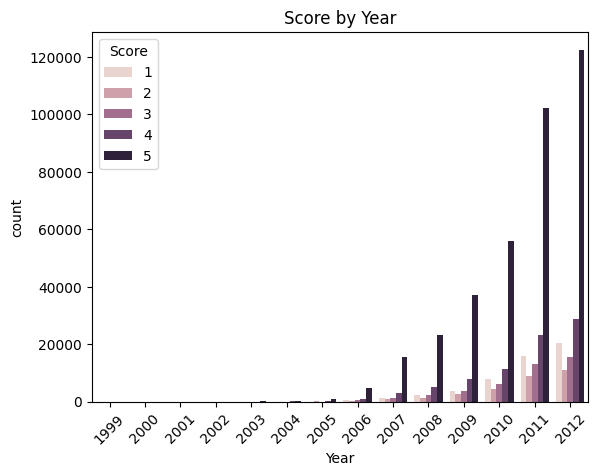

In [ ]:
# Ratings by year

sns.countplot(x='Year', hue='Score', data=data)
plt.title("Score by Year")
plt.xticks(rotation=45)
plt.show()

### 3.3 🛠️ **Data Preparation and Text Preprocessing**

In this step, we prepare the dataset for binary sentiment classification and clean the text data to make it suitable for training a deep learning model. This stage involves cleaning the text by
- removing punctuation and numbers
- converting the text to lowercase
- and transforming ratings into sentiment labels.
---

#### 🏷️ Labeling the Data
- Reviews with a rating of **4 or 5** are labeled as **positive** (`1`).
- Reviews with a rating of **1 or 2** are labeled as **negative** (`0`).
- **Neutral reviews** (with 3 stars) are excluded from the dataset.


In [ ]:
# Prepare the data
data['label'] = data['Score'].apply(lambda x: 1 if x >= 4 else 0)  # 1 for positive, 0 for negative
data = data[data['Score'] != 3]  # Remove 3-star reviews

# Clean the text
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace numbers
    text = re.sub(r'\d+', '#', text)
    # Convert text to lowercase
    return text.lower()

data['Text'] = data['Text'].apply(clean_text)

# Process the text
X = data['Text'].values
y = data['label'].values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, padding='post')

### 3.4 ⚙️ **Input Preparation,**

This section describes how the input sequences are standardized, the data split into training and testing sets, and the construction and training of a Convolutional Neural Network (CNN) model for sentiment classification.

---

#### 🎯 Limiting Input Length
- The sequences are padded or truncated to a fixed length (`max_length = 100`) to standardize input size for the model.



#### **⚙️ Model Building, and Training**
A Convolutional Neural Network (CNN) model was chosen for several reasons:
- **Effectiveness in Text Processing**: CNNs have proven their ability to effectively extract important features from text, making them suitable for classification tasks.
- **Capability to Handle Large Datasets**: CNNs can process large amounts of data quickly, which aligns with the size of the dataset used in this project.
- **Performance Improvement**: CNNs perform well in learning from complex patterns, enhancing the model's accuracy in sentiment classification.



In [ ]:
# Limit input length
max_length = 100  # or 150 depending on the need
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))

# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=X_pad.shape[1]))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.8775 - loss: 0.2861 - val_accuracy: 0.9432 - val_loss: 0.1642
Epoch 2/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9263 - loss: 0.1852 - val_accuracy: 0.9521 - val_loss: 0.1486
Epoch 3/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9384 - loss: 0.1569 - val_accuracy: 0.9540 - val_loss: 0.1717
Epoch 4/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9460 - loss: 0.1369 - val_accuracy: 0.9541 - val_loss: 0.1575
Epoch 5/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9499 - loss: 0.1257 - val_accuracy: 0.9547 - val_loss: 0.1779
Epoch 6/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9534 - loss: 0.1173 - val_accuracy: 0.9576 - val_loss: 0.2183
Epoch 7/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9552 - loss: 0.1134 - val_accuracy: 0.9575 - val_loss: 0.2270
Epoch 8/10
5258/5258 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9578 - loss: 0

3287/3287 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     16233
           1       0.98      0.96      0.97     88925

    accuracy                           0.95    105158
   macro avg       0.90      0.93      0.91    105158
weighted avg       0.96      0.95      0.95    105158



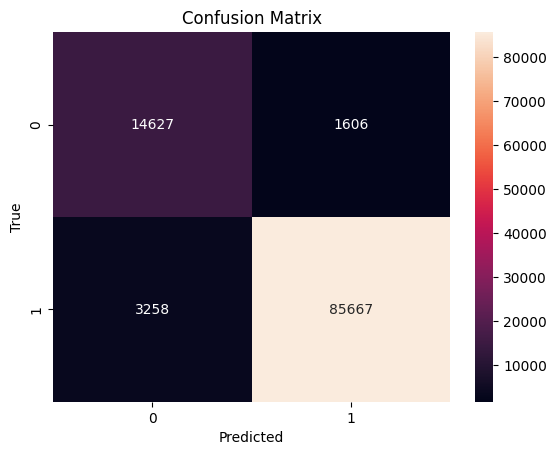

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 📊 Model Evaluation Metrics

The trained CNN model was evaluated on a test set of **105,158** reviews, yielding the following classification performance:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0 (Negative) | 0.82      | 0.90   | 0.86     | 16,233  |
| 1 (Positive) | 0.98      | 0.96   | 0.97     | 88,925  |

- **Accuracy:** 95% of all reviews were correctly classified.
- **Macro Average:** Reflects the average of precision, recall, and F1-score treating both classes equally (around 0.90 to 0.93).
- **Weighted Average:** Accounts for the class imbalance (more positive reviews), showing strong overall performance (~0.95).

**Interpretation:**

- The model performs exceptionally well on the **positive** class, with high precision and recall, meaning it rarely misses positive reviews or falsely labels negatives as positive.
- For the **negative** class, the recall is strong (0.90), capturing most negative reviews, although precision is somewhat lower (0.82), indicating some false positives.
- Overall, these metrics demonstrate a balanced and reliable sentiment classifier despite the dataset imbalance.


### 🔍 Confusion Matrix Breakdown

|                 | Predicted Negative | Predicted Positive |
|-----------------|--------------------|--------------------|
| **Actual Negative** | **14,627** True Negatives (correct)  | 1,606 False Positives (Type I error) |
| **Actual Positive** | 3,258 False Negatives (Type II error) | **85,667** True Positives (correct) |

- **True Negatives (14,627):** Negative reviews correctly identified.
- **False Positives (1,606):** Negative reviews incorrectly predicted as positive.
- **False Negatives (3,258):** Positive reviews incorrectly predicted as negative.
- **True Positives (85,667):** Positive reviews correctly identified.

This matrix clearly shows how the model performs per class and highlights the types of errors made.


3287/3287 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


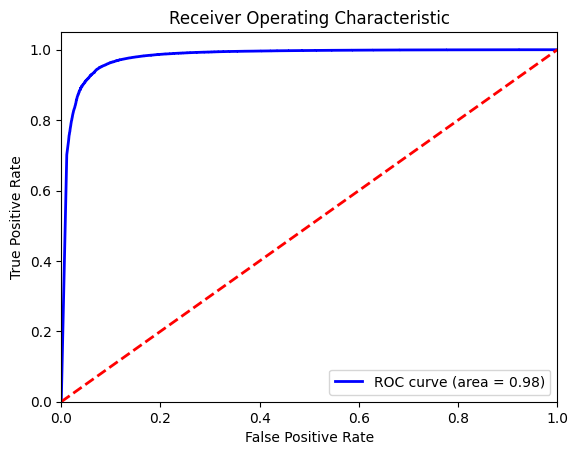

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predictions
y_pred_prob = model.predict(X_test).ravel()  # Use .ravel() to convert to a 1D array

# Calculate TPR and FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)  # Calculate the area under the curve

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 📈 ROC Curve and AUC

- The ROC curve approaches the top-left corner, indicating strong performance.
- The AUC score of **0.98** reflects excellent ability to distinguish between positive and negative sentiments.
- This demonstrates the model’s high discriminatory power and reliability in classification.



## 4. **Conclusion**
In conclusion, this project successfully developed an effective model for classifying the sentiment of Amazon reviews. Through a systematic approach, we explored and cleaned the data, built a capable model that learns from complex patterns, and achieved accurate sentiment classification results.

<!-- Add your comment here -->